#  Disentangled Sequential Variational Autoencoder using Tensorflow Probability

## Introduction

> This notebook is in very early stages of development and is not ready for public consumption.
When it is complete...

### Definition

Here we develop and test a disentangled sequential variational autoencoder. Let's break that down.

An **autoencoder** first encodes an input into a low-dimensional latent representation (a.k.a. compress, bottleneck), and from there decodes (a.k.a. generates) an output that resembles the input.

As our input is a multidimensional timeseries or sequence, and we use sequence-based methods like recurrent LSTM, this is called a **sequential autoencoder**.

As the inputs to the decoder are not deterministic variables, but are prescribed to be random variables (typically gaussian), this is called **variational**.

Finally, the training is designed so that the model learns to encode a latent representation that is split into features that **disentangle** time-dependent features (dynamics) and static features (content / context). Note that disentangled auto-encoders are by necessity variational, so we could drop the implied "variational" from our title. Alternatively, the disentanglement is often parameterized by a $\beta$ , so this could also be called a $\beta$-VAE.

### Application

An autoencoder can be trained in a self-supervised manner. That is, we don't need to care about the data labels to train it. This is greate because labeling data is often the most difficult part about getting training data.

Once trained, there are several applications for such a model.

The decoder part of the model is generative: we can provide an initial condition and then generate a realistic signal. For brain signals, this might be a useful tool to understand the model. In other domains, this can be used to generate animations / audio / video with e.g. the same movements, but the characteristics of the object changes.

The encoder part of the model takes a real input and compresses it to a meaningful latent representation. We know it is meaningful because it is sufficient to generate the input. These latent feature vectors are much more tractable as inputs into a simple decoder. Thus, the autoencoder can first be trained using all unlabeled data, then the encoder part can be transferred as the top layers of a new classification model that is further trained on a smaller labeled data set.

### Resources

[Li and Mandt, ICML 2018](https://arxiv.org/pdf/1803.02991.pdf)

[TF Probability examples](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py)

## Prepare Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys


try:
    # See if we are running on google.colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
        
    !pip install git+https://github.com/SachsLab/indl.git
    !pip install -q kaggle
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.layers as tfkl
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
if IN_COLAB:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

## Prepare Data

While I'm figuring this out, I'll use a contrived dataset. Let's assume that we have N_LATENT different latent variables. Each latent variable evolves over time. The evolution of each latent (i.e., its dynamics) over time is described by a sinusoid. The sinusoid is modulated by a sigmoid function with amplitude conditioned on the trial label, of which there are N_CLASSES distinct classes. The evolved conditionally-dependent latent variables are then mixed to yield N_SENSORS sensor-space signals, using a static mixing matrix.

In [66]:
from indl.misc.sigfuncs import sigmoid
from functools import partial


N_LATENTS = 4
N_SENSORS = 32
N_CLASSES = 5
FS = 64
DURATION = 2  # seconds
n_timesteps = int(DURATION * FS)

np.random.seed(0)
x = np.arange(n_timesteps) / FS
mix_mat = np.random.randn(N_SENSORS, N_LATENTS)
lat_freqs = np.random.randn(N_LATENTS)
class_amps = np.random.randn(N_CLASSES)

latent_protos = np.sin(lat_freqs[:, None]*2*np.pi*x[None, :])
f_sig = partial(sigmoid, B=5, x_offset=1.0)
latent_mods = class_amps[:, None] * f_sig(x)[None, :]
latent_class_dat = latent_mods[None, :, :] * latent_protos[:, None, :]
sensor_class_dat = mix_mat @ latent_class_dat.reshape(N_LATENTS, N_CLASSES * n_timesteps)
sensor_class_dat = sensor_class_dat.reshape(N_SENSORS, N_CLASSES, n_timesteps)
sensor_class_dat = np.transpose(sensor_class_dat, [1, 0, 2])
print(sensor_class_dat.shape)

(5, 32, 128)


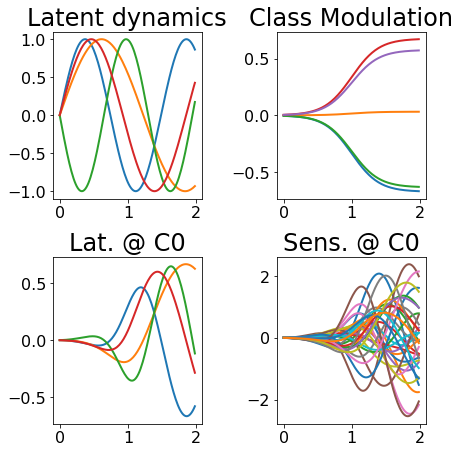

In [67]:
plt.subplot(2, 2, 1)
plt.plot(x, latent_protos.T)
plt.title("Latent dynamics")

plt.subplot(2, 2, 2)
plt.plot(x, latent_mods.T)
plt.title("Class Modulation")

plot_class_ix = 0
plt.subplot(2, 2, 3)
plt.plot(x, latent_class_dat[:, plot_class_ix, :].T)
plt.title(f"Lat. @ C{plot_class_ix}")

plt.subplot(2, 2, 4)
plt.plot(x, sensor_class_dat[plot_class_ix, :, :].T)
plt.title(f"Sens. @ C{plot_class_ix}")

plt.tight_layout()
plt.show()

We will draw samples from `sensor_class_dat` with added noise.
Compare the plotted example below to the plot from the lower-right pane above.

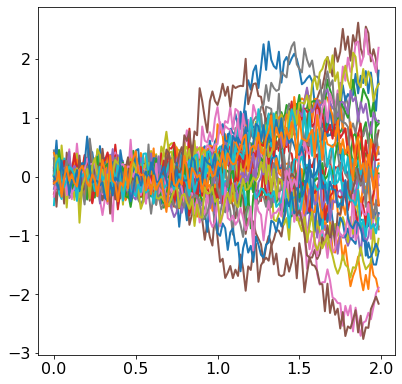

In [86]:
def draw_samples(class_idx, noise_std=0.2):
    dat = np.copy(sensor_class_dat[class_idx]).astype(np.float32)
    dat += np.random.normal(loc=0, scale=noise_std, size=dat.shape)
    return dat
    
plt.plot(x, draw_samples([plot_class_ix])[0].T)
plt.show()

In [165]:
class ContrivedDataset(tf.data.Dataset):
    def _generator(num_samples):
        for class_idx in np.random.randint(0, high=N_CLASSES, size=num_samples):
            X = draw_samples(class_idx, noise_std=0.2)
            yield (X.T, [class_idx])
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=(tf.dtypes.float32, tf.dtypes.int64),
            output_shapes=((n_timesteps, N_SENSORS), 1),
            args=(num_samples,)
        )

## Sanity Check - GRU Classifier

We want to make sure that we can train a recurrent model to classify the data. As one of the main use-cases for us for an AE is for model pretraining and transfer to the classifier task, we would not usually *start* with classification. Here we are running a classifier first just to make sure our model isn't insane.

In [166]:
N_TRIALS = 10000    
dataset = ContrivedDataset(N_TRIALS).batch(100)

In [167]:
N_GRU = 100
N_EPOCHS = 5

tf.keras.backend.clear_session()
model = tf.keras.Sequential(
    [tfkl.GRU(N_GRU, input_shape=dataset.element_spec[0].shape[1:], return_sequences=False),
     tfkl.Dense(N_CLASSES, activation='softmax')]
)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(dataset, epochs=N_EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               40200     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
100/100 [==============================] - 13s 133ms/step - loss: 0.6468 - accuracy: 0.6956
Epoch 2/5
100/100 [==============================] - 12s 118ms/step - loss: 0.3009 - accuracy: 0.8445
Epoch 3/5
100/100 [==============================] - 12s 118ms/step - loss: 0.2497 - accuracy: 0.9070
Epoch 4/5
100/100 [==============================] - 12s 118ms/step - loss: 0.1805 - accuracy: 0.9369
Epoch 5/5
100/100 [==============================] - 12s 119ms/step - loss: 0.1053 - accuracy: 0.9638


In [168]:
pred_y = []
true_y = []
for ix, batch in dataset.enumerate(10):
    pred_y.append(np.argmax(model.predict(batch[0]), axis=1))
    true_y.append(batch[1].numpy())

tf.Tensor(
[[2041    0    1    0    0]
 [   0 2002    0    0    0]
 [   0    0 1990    0    0]
 [   0    0    0 1924    0]
 [   0    0    0    0 2042]], shape=(5, 5), dtype=int32)


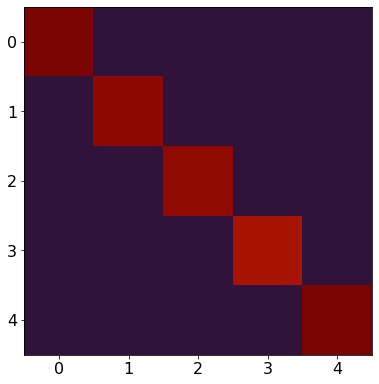

In [169]:
import indl.display  # To register 'turbo'


conf_mat = tf.math.confusion_matrix(np.array(true_y).flatten(), np.array(pred_y).flatten(), num_classes=N_CLASSES)
plt.imshow(conf_mat, cmap='turbo')
print(conf_mat)

## Basic Sequential Autoencoder

Before we get into the fancy **disentangled & variational** autoencoder, let's start with a simple one.

### Modify dataset

The autoencoder tries to reconstruct the input, so we need the 'labels' in the dataset to be a copy of the input. We do this by mapping a function to the dataset, where the function is a simple lambda that takes in x,y and returns x,x.

In [170]:
N_TRIALS = 10000    
dataset = ContrivedDataset(N_TRIALS).batch(100).map(lambda x, y: (x, x))
print(dataset.element_spec)

(TensorSpec(shape=(None, 128, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 32), dtype=tf.float32, name=None))


Below we take the single timestep output of the encoder GRU and repeat it to be as long as the timesteps on the input. This is not the only way. TODO: Try other ways.

* Set decoder hidden state using encoder output, then feedback output of decoder into itself
* Set hidden state and/or first input, then the rest of the inputs are zeros.

[See here](https://stackoverflow.com/a/55000744/1256069)

In [189]:
N_EPOCHS = 6
LATENT_DIM = 100

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tfkl.GRU(LATENT_DIM, input_shape=dataset.element_spec[0].shape[1:], return_sequences=False),  # encoder
    tfkl.RepeatVector(dataset.element_spec[0].shape[1]),
    tfkl.GRU(dataset.element_spec[0].shape[2], return_sequences=True)  # decoder
])
model.summary()
model.compile(loss='mse', 
              optimizer='adam')
history = model.fit(dataset, epochs=N_EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               40200     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 128, 100)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 32)           12864     
Total params: 53,064
Trainable params: 53,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 34s 341ms/step - loss: 0.3301
Epoch 2/10
100/100 [==============================] - 32s 321ms/step - loss: 0.2839
Epoch 3/10
100/100 [==============================] - 32s 321ms/step - loss: 0.1998
Epoch 4/10
100/100 [==============================] - 32s 321ms/step - loss: 0.1733
Epoch 5/10
100/100 [==========================

In [190]:
for ix, batch in dataset.enumerate(1):
    pred_x = model(batch[0]).numpy()
    true_x = batch[0].numpy()

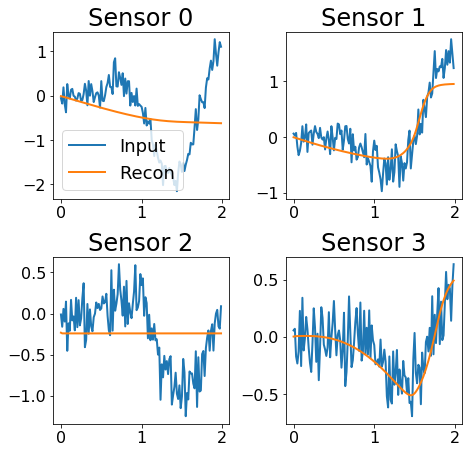

In [192]:
trial_ix = 15
for chan_ix in range(4):
    plt.subplot(2, 2, chan_ix + 1)
    plt.plot(x, true_x[trial_ix, :, chan_ix], label="Input")
    plt.plot(x, pred_x[trial_ix, :, chan_ix], label="Recon")
    plt.title(f"Sensor {chan_ix}")
    if chan_ix == 0:
        plt.legend()

plt.tight_layout()
plt.show()

## Variational Autoencoder with vanilla TF and Keras

Next, we take the relatively large step of making the variational autoencoder using vanilla TF. This is quite a bit more involved than making it with TF-Probability, which we will see later.

Much of this was taken from the Keras blog [here](https://blog.keras.io/building-autoencoders-in-keras.html) and a LSTM variant [found here](https://github.com/twairball/keras_lstm_vae/blob/master/lstm_vae/vae.py).

... had to leave before I could finish. Will resume later.

In [ ]:
N_EPOCHS = 10
N_GRU = 100
LATENT_DIM = 32

tf.keras.backend.clear_session()

_x = tfkl.Input(shape=dataset.element_spec[0].shape[1:])
_x = tfkl.GRU(N_GRU)(_x)
_mean = tfkl.Dense(LATENT_DIM)(_x)
_log_sigma = tfkl.Dense(LATENT_DIM)(_x)


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

_z = tfkl.Lambda(sampling, output_shape=(LATENT_DIM,))([_mean, _log_sigma])

#
_y = tfkl.RepeatVector(dataset.element_spec[0].shape[1])(_z)
_y = tfkl.GRU(N_GRU, return_sequences=True)(_y)


decoder_h = tfkl.GRU(N_GRU, return_sequences=True)
decoder_mean = tfkl.GRU(input_dim, return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)

# decoded layer
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

model = tf.keras.Sequential([
    tfkl.GRU(LATENT_DIM, input_shape=dataset.element_spec[0].shape[1:], return_sequences=False),  # encoder
    tfkl.RepeatVector(dataset.element_spec[0].shape[1]),
    tfkl.GRU(dataset.element_spec[0].shape[2], return_sequences=True)  # decoder
])
model.summary()
model.compile(loss='mse', 
              optimizer='adam')
#history = model.fit(dataset, epochs=N_EPOCHS)